Дашборд
https://datalens.yandex/2cmj7nzz3r40q

In [1]:
import pandas as pd
import re
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import networkx as nx
from dateutil.relativedelta import relativedelta

pd.set_option('display.max_columns', None)
pd.reset_option('display.max_columns')
plt.rc('figure', figsize=(15, 6))
pd.options.display.float_format = '{:,.2f}'.format

**Цель проекта**  
*Визуализация данных по объектам*

Заказчика интересует информация, разбитая по округам, включая:
- Общее количество объектов.
- Способы их классификации.
- Общие характеристики объектов.
- Локализацию объектов.
- Количество и распределение проверок по объектам.
- Распределение нагрузки между проверками.
- Частота проведения проверок и количество выявленных нарушений.

**Этапы**
1. Предобработка
2. Провести исследовательский анализ данных;
3. Визуализировать данные в дашборд.

**Описание данных**  
Для работы представлено 2 файла с описанием мероприятий и объктов.  

In [2]:
# Данные по всем объектам, зарегестрированным в реестре
estate_coor = pd.read_csv('data.csv', on_bad_lines='skip', skiprows=[0], sep=';')

C:\Users\User\AppData\Local\Temp\ipykernel_14380\2520871605.py:2: DtypeWarning: Columns (11,13,18,21,34) have mixed types. Specify dtype option on import or set low_memory=False.
  estate_coor = pd.read_csv('data.csv', on_bad_lines='skip', skiprows=[0], sep=';')


In [3]:
#Данные по задачам
tasks = pd.read_excel('mos.xlsx', skiprows=[0])

In [4]:
#Данные о мероприятиях
events = pd.read_excel('mos.xlsx', sheet_name='Мероприятия', skiprows=[0])

In [5]:
#Данные о объектах
estate = pd.read_excel('mos.xlsx', sheet_name='Объекты', skiprows=[0])

In [6]:
# функция сбора информации по датасетам
def show_stats(df):

    start_shape = df.shape
    mins, means, medians, maxs = [], [], [], []
    stats_df = pd.DataFrame(index=df.columns.tolist())
    stats_df['dtype'] = [df[col].dtypes for col in df.columns]
    stats_df['memory_usage'] = df.memory_usage(deep=True)
    stats_df['nans_count'] = df.isna().sum().tolist()
    stats_df['nans_ratio_%'] = (df.isna().mean() * 100).round(2)
    stats_df['uniques'] = [df[col].nunique() for col in df.columns]
    for col in df.columns:
        if df[col].dtypes in ['int64', 'int32', 'int16', 'int8', 'Int8', 'Int16', 'float']:
            mins.append(round(df[col].min(), 2))
            means.append(round(df[col].mean(), 2))
            medians.append(round(df[col].median(), 2))
            maxs.append(round(df[col].max(), 2))
        else:
            mins.append(np.nan)
            means.append(np.nan)
            medians.append(np.nan)
            maxs.append(np.nan)
    stats_df['min'], stats_df['mean'], stats_df['median'], stats_df['max'] = mins, means, medians, maxs
    def format_nan_to_empty(val):
        return '' if pd.isna(val) else val
    s_style = '\x1b[6;30;42m'
    e_style = '\x1b[0m'
    print('------------------------------------------')
    print(s_style + 'Основная информация по колонкам таблицы:' + e_style)
    print('Количество строк:', start_shape[0], \
          '\nКоличество колонок:', start_shape[1], \
          '\nОбщее потребление памяти датасетом: {:.2f} MB'.format(stats_df['memory_usage'].sum() / (1024 * 1024)))
    display(stats_df.style            
            .format('{:.2f}', subset=['nans_ratio_%', 'min', 'mean', 'median', 'max'])
            .format(format_nan_to_empty)
           .background_gradient(cmap='coolwarm', subset=['nans_ratio_%']))
    dubl_count = df.duplicated().sum()
    dubl_ratio = round(dubl_count / start_shape[0] * 100, 2)
    print('------------------------------------------')
    print(s_style +'Явные дубликаты:                         ' + e_style )
    print('Число явных дубликатов:', dubl_count, \
          '\nДоля явных дубликатов от всего датасета:', dubl_ratio, '%')
    print(s_style +'\nПервые 5 строк:                          ' + e_style )
    display(df.head(2))

In [7]:
show_stats(estate_coor)

------------------------------------------
Основная информация по колонкам таблицы:
Количество строк: 491295 
Количество колонок: 45 
Общее потребление памяти датасетом: 1772.02 MB


,dtype,memory_usage,nans_count,nans_ratio_%,uniques,min,mean,median,max
global_id,int64,3930360,0,0.0,491293,645622141.0,1164043346.4,1037643199.0,2664632224.0
Тип объекта адресации,object,50595252,0,0.0,4,,,,
На территории Москвы,object,42251534,0,0.0,2,,,,
Полное юридическое написание адреса или описание местоположения,object,145791614,0,0.0,490930,,,,
Учётный номер объекта адресации в БД БТИ (кроме помещения и комнаты),int64,3930360,0,0.0,491293,1.0,4382485.26,5124169.0,9000004.0
Субъект РФ,object,52077270,0,0.0,1,,,,
Поселение,object,44253098,185500,37.76,21,,,,
Город,object,16929186,475860,96.86,4,,,,
Муниципальный округ,object,35546268,314539,64.02,125,,,,
Населённый пункт,object,28701698,337489,68.69,314,,,,


------------------------------------------
Явные дубликаты:                         
Число явных дубликатов: 2 
Доля явных дубликатов от всего датасета: 0.0 %

Первые 5 строк:                          


,global_id,Тип объекта адресации,На территории Москвы,Полное юридическое написание адреса или описание местоположения,Учётный номер объекта адресации в БД БТИ (кроме помещения и комнаты),Субъект РФ,Поселение,Город,Муниципальный округ,Населённый пункт,...,Документ-основание регистрационных действий,Номер документа о регистрации адреса,Дата документа о регистрации адреса,Тип адреса,Вид адреса,Состояние адреса,Статус адреса,geoData,geodata_center,Unnamed: 44
0,645622141,Здание,да,"Российская Федерация, город Москва, внутригоро...",2102436,город Москва,NaN,NaN,муниципальный округ Вешняки,NaN,...,Распоряжение префектуры АО города Москвы,875-В-РП,28.07.2004,Официальный,Адрес,Зарегистрирован в АР,Внесён в ГКН,"{coordinates=[[[37.827950455, 55.717660993], [...","{coordinates=[37.828189394, 55.717482785], typ...",NaN
1,645622142,Здание,да,"Российская Федерация, город Москва, внутригоро...",5783,город Москва,NaN,NaN,муниципальный округ Басманный,NaN,...,Распоряжение префектуры АО города Москвы,3026-р,04.07.2005,Официальный,Адрес,Зарегистрирован в АР,Внесён в ГКН,"{coordinates=[[[37.668299521, 55.766243148], [...","{coordinates=[37.668013072, 55.766228272], typ...",NaN


In [8]:
show_stats(tasks)

------------------------------------------
Основная информация по колонкам таблицы:
Количество строк: 2758 
Количество колонок: 8 
Общее потребление памяти датасетом: 1.95 MB


,dtype,memory_usage,nans_count,nans_ratio_%,uniques,min,mean,median,max
№ п/п,int64,22064,0,0.0,2758,15.0,3865.18,3928.5,7683.0
Id задачи,int64,22064,0,0.0,2758,203297.0,1005716.63,1036778.0,1065090.0
Источник задачи,object,293948,0,0.0,8,,,,
Округ,object,240012,86,3.12,13,,,,
Район,object,279206,97,3.52,144,,,,
Тематика,object,926688,0,0.0,1,,,,
Тип объекта,object,237188,0,0.0,2,,,,
№ распоряжения/поручения,int64,22064,0,0.0,2757,9010005.0,9053427.65,9046255.5,9118135.0


------------------------------------------
Явные дубликаты:                         
Число явных дубликатов: 0 
Доля явных дубликатов от всего датасета: 0.0 %

Первые 5 строк:                          


,№ п/п,Id задачи,Источник задачи,Округ,Район,Тематика,Тип объекта,№ распоряжения/поручения
0,15,1065090,Поручение,ЮАО,Чертаново Центральное,819/829-ПП (мероприятия по выявлению и пресече...,ЗУ,9052574
1,17,1065037,Поручение,NaN,NaN,819/829-ПП (мероприятия по выявлению и пресече...,ЗУ,9048265


- В данных нет явных дубликатов.
- В данных есть незначительные пропуски.
- Возможно эти данные можно будет восполнить далее.
- Формат определился корректно
- № распоряжения/поручения уникальное поле, содержаще 2757 значений

In [9]:
show_stats(events)

------------------------------------------
Основная информация по колонкам таблицы:
Количество строк: 3219 
Количество колонок: 41 
Общее потребление памяти датасетом: 7.96 MB


,dtype,memory_usage,nans_count,nans_ratio_%,uniques,min,mean,median,max
№ п/п,int64,25752,0,0.0,3219,3.0,2236.94,2203.0,4576.0
Идентификатор мероприятия,int64,25752,0,0.0,3219,1081684.0,1116203.99,1116760.0,1147581.0
№ проверки,object,206959,0,0.0,3176,,,,
Дата создания карточки,datetime64[ns],25752,0,0.0,3217,,,,
Вид мероприятия,object,403686,0,0.0,2,,,,
Дата обновления карточки,datetime64[ns],25752,0,0.0,3217,,,,
Дата проверки/обсл,datetime64[ns],25752,0,0.0,289,,,,
Дата акта,datetime64[ns],25752,0,0.0,288,,,,
Продолжительность (час),float64,25752,0,0.0,68,0.02,0.25,0.13,4.0
Время начала осмотра,object,199578,0,0.0,536,,,,


------------------------------------------
Явные дубликаты:                         
Число явных дубликатов: 0 
Доля явных дубликатов от всего датасета: 0.0 %

Первые 5 строк:                          


,№ п/п,Идентификатор мероприятия,№ проверки,Дата создания карточки,Вид мероприятия,Дата обновления карточки,Дата проверки/обсл,Дата акта,Продолжительность (час),Время начала осмотра,...,Площадь пресечения,Ведется строительство,Пресечено строительство,Строительство возобновлено,Незавершенное строительство,Наличие признаков угроз,Признаки угроз,ID НТО,ID объекта самостроя,Нарушение ОАТИ
0,3,1147581,9048253,2024-03-12 16:35:38,Выездное обследование,2024-03-12 19:13:25,2024-03-12,2024-03-12,0.07,13:18,...,NaN,Нет,Нет,Нет,Нет,Нет,NaN,NaN,58817,Нет
1,4,1147557,9052574,2024-03-12 13:59:36,Выездное обследование,2024-03-13 12:30:44,2024-03-12,2024-03-12,0.07,10:09,...,NaN,Нет,Нет,Нет,Нет,Нет,NaN,NaN,58730,Нет


В данных отсутсвуют явные дубликаты. 
Много колонок которые содержат только одно значние.
№ проверки содержит только уникальные значние

In [10]:
#удалим колонки с одним значнием и дублируюшие информацтю
events = events.drop(columns=['Верифицировано', 'Состояние верификации', 'Тип проверки/обследования','Наличие предостережения', 'Отказ от ознакомления с актом', 'Тип объекта' , 'Ведется строительство', 'Пресечено строительство', 'Строительство возобновлено', 'Обращение на портал «Наш город»', 'Машино-место', 'Незавершенное строительство','Наличие признаков угроз','Признаки угроз', 'Площадь пресечения', 'ID НТО', 'Нарушение ОАТИ'])

In [11]:
show_stats(estate)

------------------------------------------
Основная информация по колонкам таблицы:
Количество строк: 2937 
Количество колонок: 40 
Общее потребление памяти датасетом: 7.14 MB


,dtype,memory_usage,nans_count,nans_ratio_%,uniques,min,mean,median,max
№ п/п,int64,23496,0,0.0,2937,1.0,1857.26,1852.0,3949.0
Идентификатор объекта,int64,23496,0,0.0,2937,12225.0,53513.76,54477.0,58817.0
Название объекта,object,303234,0,0.0,2937,,,,
Дата создания карточки объекта,datetime64[ns],23496,0,0.0,2937,,,,
Основание выявления/первого обследования,object,389134,0,0.0,16,,,,
Вид мероприятия,object,359288,200,6.81,3,,,,
Округ,object,304662,0,0.0,13,,,,
Район,object,304672,0,0.0,145,,,,
Тип объекта,object,287662,0,0.0,12,,,,
Площадь/длина самостроя,float64,23496,0,0.0,1808,0.0,490.48,114.0,54279.7


------------------------------------------
Явные дубликаты:                         
Число явных дубликатов: 0 
Доля явных дубликатов от всего датасета: 0.0 %

Первые 5 строк:                          


,№ п/п,Идентификатор объекта,Название объекта,Дата создания карточки объекта,Основание выявления/первого обследования,Вид мероприятия,Округ,Район,Тип объекта,Площадь/длина самостроя,...,Дата первого КИМ,Дата акта первого КИМ,Результат первого КИМ,Состояние верификации первого КИМ,ID последнего КИМ,№ последнего КИМ,Дата последнего КИМ,Дата акта последнего КИМ,Результат последнего КИМ,Состояние верификации последнего КИМ
0,1,58817,Объект 1,2024-03-12 17:19:37,Обследование не проводилось. Выявлен ГИН,NaN,Юго-Восточный,Печатники,прочее,"1,391.00",...,2024-03-12,2024-03-12,Нецелевое использование ЗУ (прил. №3),Верифицировано,1147581,9048253,2024-03-12,2024-03-12,Нецелевое использование ЗУ (прил. №3),Верифицировано
1,2,58805,Объект 2,2024-03-12 11:59:21,Поручения руководителя,Выездное обследование,Юго-Восточный,Люблино,пристройка,78.50,...,2024-03-11,2024-03-11,Нецелевое использование ЗУ (прил. №3),Верифицировано,1147542,9048265,2024-03-11,2024-03-11,Нецелевое использование ЗУ (прил. №3),Верифицировано


В данных отсутсвуют явные дубликаты. 
Много колонок которые содержат только одно значние.
Идентификатор объекта содержит только уникальные значние

In [12]:
#удалим колоки, которые мы можем восполнить по мероприятиям
estate = (estate.drop(columns=['Основание выявления/первого обследования', 'Вид мероприятия', 'ID первого КИМ','№ первого КИМ',
                     'Дата первого КИМ',
                     'Дата акта первого КИМ',
                     'Результат первого КИМ',
                     'Состояние верификации первого КИМ',
                     'ID последнего КИМ',
                     '№ последнего КИМ',
                     'Дата последнего КИМ',
                     'Дата акта последнего КИМ',
                     'Результат последнего КИМ',
                     'Состояние верификации последнего КИМ']))

## Исследовательский анализ

In [13]:
tasks.head()

,№ п/п,Id задачи,Источник задачи,Округ,Район,Тематика,Тип объекта,№ распоряжения/поручения
0,15,1065090,Поручение,ЮАО,Чертаново Центральное,819/829-ПП (мероприятия по выявлению и пресече...,ЗУ,9052574
1,17,1065037,Поручение,NaN,NaN,819/829-ПП (мероприятия по выявлению и пресече...,ЗУ,9048265
2,32,1064674,ЭДО обращение ОИВ,ЦАО,Басманный,819/829-ПП (мероприятия по выявлению и пресече...,ЗУ,9072563
3,39,1064612,Поручение,ВАО,Богородское,819/829-ПП (мероприятия по выявлению и пресече...,ЗУ,9038375
4,44,1064538,Инструментальный мониторинг,ЮВАО,Печатники,819/829-ПП (мероприятия по выявлению и пресече...,ЗУ,9048253


In [14]:
tasks['Источник задачи'].value_counts()

Источник задачи
Поручение                          1824
ЭДО обращение ОИВ                   533
Камеральная проверка                134
Мониторинг ОИВ                      106
Инструментальный мониторинг          92
Межведомственное взаимодействие      34
ЭДО обращение граждан                29
Портал "Наш город"                    6
Name: count, dtype: int64

Данное поле необходимо для дашборда.  
Больше всего в данных поручений

In [15]:
tasks['Округ'].value_counts()

Округ
ЦАО      560
ЮВАО     431
ВАО      328
ЮАО      259
СВАО     254
ЗАО      196
САО      191
СЗАО     144
ЗЕЛАО     97
НАО       97
ТАО       74
ЮЗАО      40
МО         1
Name: count, dtype: int64

ЦАО выделяется с максимальным числом задач.  
Московская область тоже попала в данные. Но количство незначительное 

In [16]:
tasks['Район'].value_counts()

Район
Басманный               185
Таганский                95
Печатники                85
Тверской                 84
Соколиная Гора           70
                       ... 
Нагатинский Затон         2
Северное Бутово           1
Истринский                1
Ломоносовский             1
Проспект Вернадского      1
Name: count, Length: 144, dtype: int64

In [17]:
tasks['Тип объекта'].value_counts()

Тип объекта
ЗУ    2754
НФ       4
Name: count, dtype: int64

В данных есть информация о земельных участках и нежелом фонде.

In [18]:
events.head()

,№ п/п,Идентификатор мероприятия,№ проверки,Дата создания карточки,Вид мероприятия,Дата обновления карточки,Дата проверки/обсл,Дата акта,Продолжительность (час),Время начала осмотра,...,Статьи нарушений,Проверка/обсл. в отношении,Фактическое использование,Комплексное использование,"Площадь факт. исп., кв.м.",Округ,Район,Площадь объекта,Право пользования,ID объекта самостроя
0,3,1147581,9048253,2024-03-12 16:35:38,Выездное обследование,2024-03-12 19:13:25,2024-03-12,2024-03-12,0.07,13:18,...,ч.1.2 ст.6.7,ЮЛ/ИП,прочее,Нет,NaN,ЮВАО,Печатники,"1,391.00",NaN,58817
1,4,1147557,9052574,2024-03-12 13:59:36,Выездное обследование,2024-03-13 12:30:44,2024-03-12,2024-03-12,0.07,10:09,...,ч.1.2 ст.6.7,ФЛ,придомовая территория,Нет,NaN,ЮАО,Чертаново Центральное,25.00,Земельно-правовые отношения не оформлены,58730
2,6,1147542,9048265,2024-03-12 12:30:29,Выездное обследование,2024-03-13 12:30:56,2024-03-11,2024-03-11,0.20,16:12,...,ч.1.2 ст.6.7,ФЛ,прочее,Нет,NaN,ЮВАО,Люблино,"5,500.00",NaN,58805
3,7,1147482,9106315,2024-03-11 21:11:41,Функциональное мероприятие,2024-03-11 21:41:32,2024-03-06,2024-03-06,0.03,14:04,...,NaN,ЮЛ/ИП,деятельность не ведется,Нет,NaN,ЗЕЛАО,Силино,"4,542.00",Земельно-правовые отношения не оформлены,51892
4,8,1147479,9106356,2024-03-11 20:58:04,Функциональное мероприятие,2024-03-11 21:46:38,2024-03-06,2024-03-06,0.03,14:01,...,NaN,ЮЛ/ИП,деятельность не ведется,Нет,NaN,ЗЕЛАО,Силино,"4,700.00",Земельно-правовые отношения не оформлены,51893


In [19]:
#заменим знак дроби для обьединения таблитц
events['№ проверки без/'] = events['№ проверки'].str.split('/').str[0]

In [20]:
#отдельно выделим день недели чтобы посмотреть в каки дни больше всего мероприятий 
events['День недели проверки'] = events['Дата проверки/обсл'].dt.weekday

events['День недели проверки'] = events['День недели проверки'].map({ 0:1,
                                         1:2,
                                         2:3,
                                         3:4,
                                         4:5,
                                         5:6,
                                         6:7})

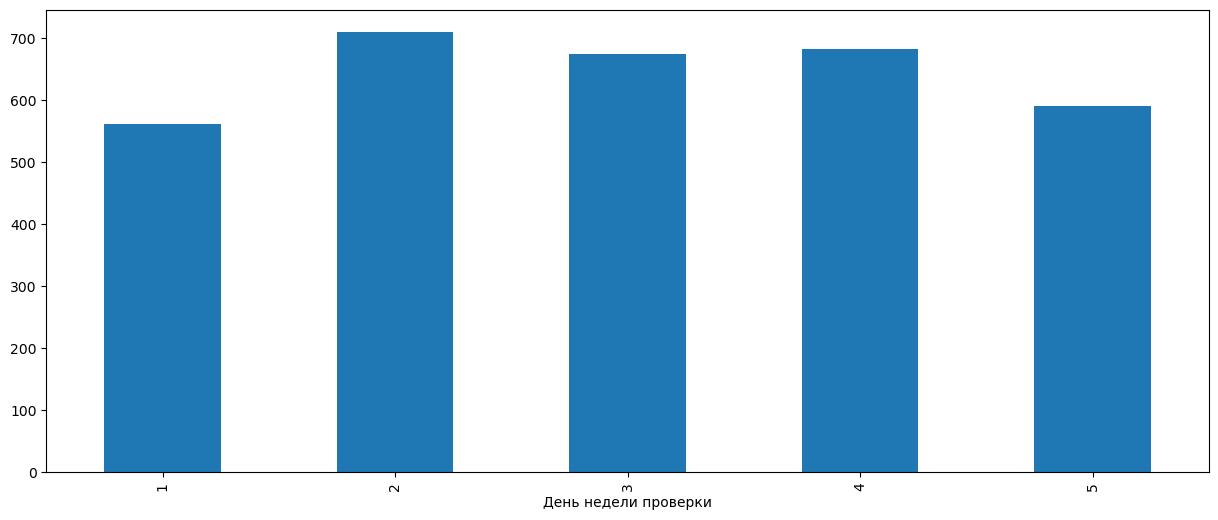

In [21]:
events['День недели проверки'].value_counts().sort_index().plot.bar();

В выходные дни проверки не проходили.
Только в рабочие дния.  
Больше всего проверок во вторник

In [22]:
#проверим поля на схожесть
(estate['Площадь/длина самостроя'] == estate['Площадь объекта']).value_counts()

True     2134
False     803
Name: count, dtype: int64

В колонках есть отличия в площади с фактическим

In [23]:
#проврим неявные дубликаты в данных
events.drop(columns=['№ п/п','Идентификатор мероприятия','№ проверки']).duplicated().sum()

0

In [24]:
events.head()

,№ п/п,Идентификатор мероприятия,№ проверки,Дата создания карточки,Вид мероприятия,Дата обновления карточки,Дата проверки/обсл,Дата акта,Продолжительность (час),Время начала осмотра,...,Фактическое использование,Комплексное использование,"Площадь факт. исп., кв.м.",Округ,Район,Площадь объекта,Право пользования,ID объекта самостроя,№ проверки без/,День недели проверки
0,3,1147581,9048253,2024-03-12 16:35:38,Выездное обследование,2024-03-12 19:13:25,2024-03-12,2024-03-12,0.07,13:18,...,прочее,Нет,NaN,ЮВАО,Печатники,"1,391.00",NaN,58817,9048253,2
1,4,1147557,9052574,2024-03-12 13:59:36,Выездное обследование,2024-03-13 12:30:44,2024-03-12,2024-03-12,0.07,10:09,...,придомовая территория,Нет,NaN,ЮАО,Чертаново Центральное,25.00,Земельно-правовые отношения не оформлены,58730,9052574,2
2,6,1147542,9048265,2024-03-12 12:30:29,Выездное обследование,2024-03-13 12:30:56,2024-03-11,2024-03-11,0.20,16:12,...,прочее,Нет,NaN,ЮВАО,Люблино,"5,500.00",NaN,58805,9048265,1
3,7,1147482,9106315,2024-03-11 21:11:41,Функциональное мероприятие,2024-03-11 21:41:32,2024-03-06,2024-03-06,0.03,14:04,...,деятельность не ведется,Нет,NaN,ЗЕЛАО,Силино,"4,542.00",Земельно-правовые отношения не оформлены,51892,9106315,3
4,8,1147479,9106356,2024-03-11 20:58:04,Функциональное мероприятие,2024-03-11 21:46:38,2024-03-06,2024-03-06,0.03,14:01,...,деятельность не ведется,Нет,NaN,ЗЕЛАО,Силино,"4,700.00",Земельно-правовые отношения не оформлены,51893,9106356,3


In [25]:
events['Дата создания карточки'].apply(['min', 'max'])

min   2023-01-09 14:13:37
max   2024-03-12 16:35:38
Name: Дата создания карточки, dtype: datetime64[ns]

In [26]:
#приведем тип данных для объединения
tasks['№ распоряжения/поручения'] = tasks['№ распоряжения/поручения'].apply(str)

In [27]:
#объеденим данные по задачам и мероприятиям
df = events.merge(tasks[['Источник задачи', '№ распоряжения/поручения']], left_on='№ проверки без/', right_on = '№ распоряжения/поручения')

## Общее количество объектов.

In [28]:
df['ID объекта самостроя'].nunique()

2937

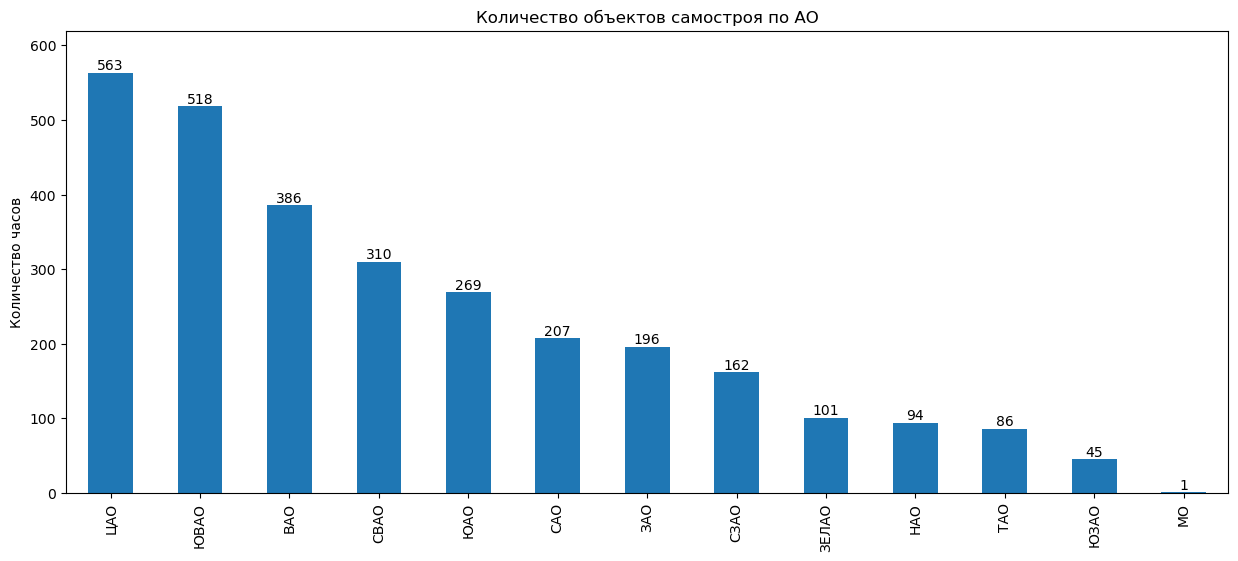

In [29]:
ax = df.groupby(['Округ'])['ID объекта самостроя'].nunique().sort_values(ascending=False).plot.bar()
ax.bar_label(ax.containers[0], label_type='edge')
ax.margins(y=0.1)
ax.set(xlabel=None, ylabel='Количество часов',title='Количество объектов самостроя по АО');

In [30]:
df.groupby(['Округ'])['ID объекта самостроя'].nunique().sort_values(ascending=False)

Округ
ЦАО      563
ЮВАО     518
ВАО      386
СВАО     310
ЮАО      269
САО      207
ЗАО      196
СЗАО     162
ЗЕЛАО    101
НАО       94
ТАО       86
ЮЗАО      45
МО         1
Name: ID объекта самостроя, dtype: int64

Больше всего объектов в ЦАО(563) и ЮВА(518)

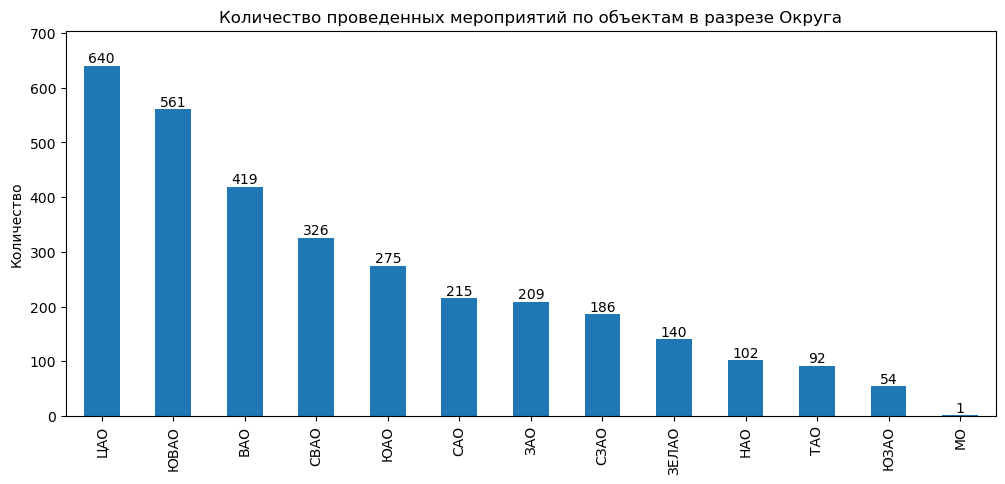

In [31]:
#визуализируем данные по количестуву меропиятий
fig, ax = plt.subplots(figsize = (12, 5))
ax = df['Округ'].value_counts().plot.bar() 

ax.bar_label(ax.containers[0], label_type='edge')
ax.margins(y=0.1)
ax.set(xlabel=None, ylabel='Количество',title='Количество проведенных мероприятий по объектам в разрезе Округа');

Больше всего мероприятий в ЦАО и ЮВАО.   
Возможно это связано с большими стройками в этих АО

## Количество проведенных мероприятий по объектам в разрезе источника задачи

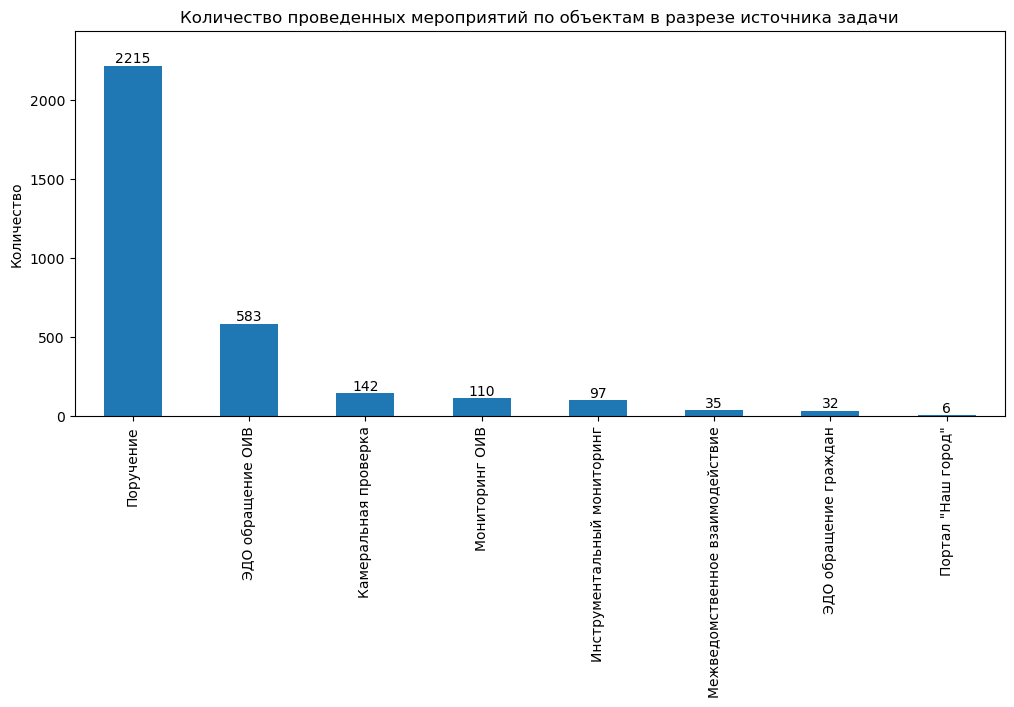

In [32]:
fig, ax = plt.subplots(figsize = (12, 5))
ax = df['Источник задачи'].value_counts().plot.bar() 

ax.bar_label(ax.containers[0], label_type='edge')
ax.margins(y=0.1)
ax.set(xlabel=None, ylabel='Количество',title='Количество проведенных мероприятий по объектам в разрезе источника задачи');

Больше всего проверки проходят по поручниям.
Также жесть обращения чрез портал "Наш город". Однако за весь период всего 5.

## Количество проведенных мероприятий по объектам в разрезе вида мероприятия

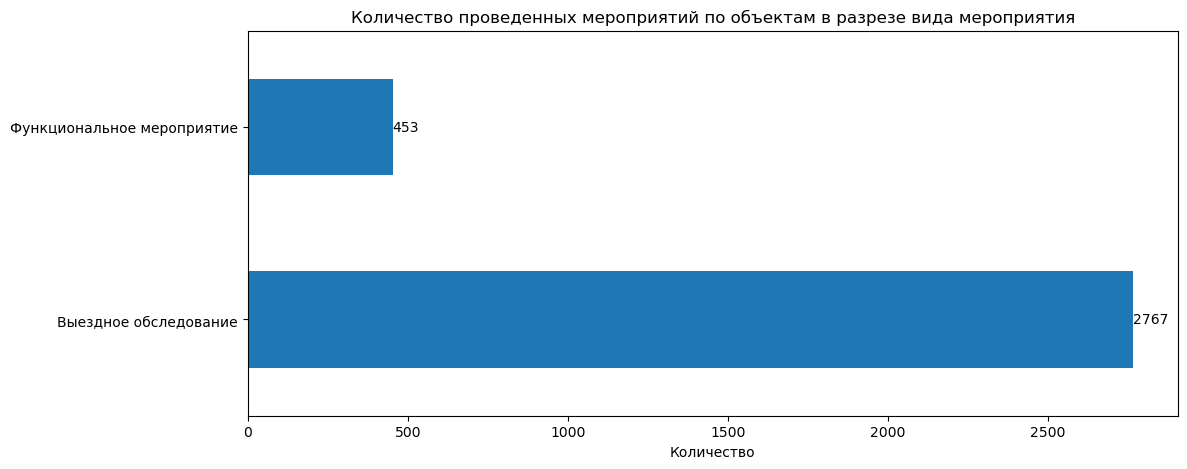

In [33]:
fig, ax = plt.subplots(figsize = (12, 5))
ax = df['Вид мероприятия'].value_counts().sort_values(ascending=False).plot.barh() 

ax.bar_label(ax.containers[0], label_type='edge')
ax.margins(y=0.1)
ax.set(ylabel=None, xlabel='Количество',title='Количество проведенных мероприятий по объектам в разрезе вида мероприятия');

Очень много выезжных мероприятий.  
Это логично, необходимо лично удостовериться о текущем состоянии и возможных нарушениях.

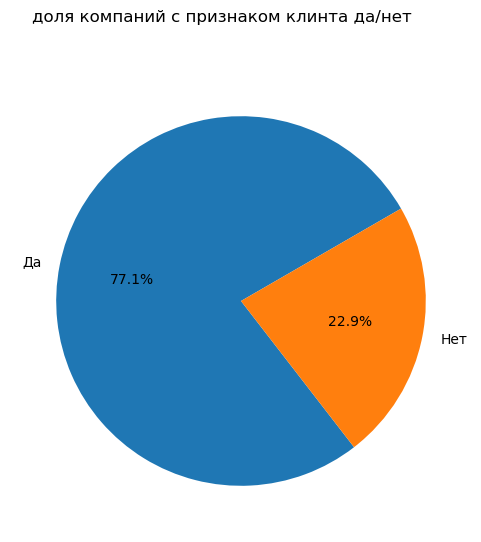

In [34]:
df['Наличие нарушения'].value_counts().plot.pie(autopct = '%1.1f%%', startangle=30)
plt.ylabel(None)
plt.suptitle('доля компаний с признаком клинта да/нет'+ '\n', fontsize=12);

Большая часть проверок заканчивается обнаружением нарушений

## Количество проведенных мероприятий по объектам в разрезе вида мероприятия

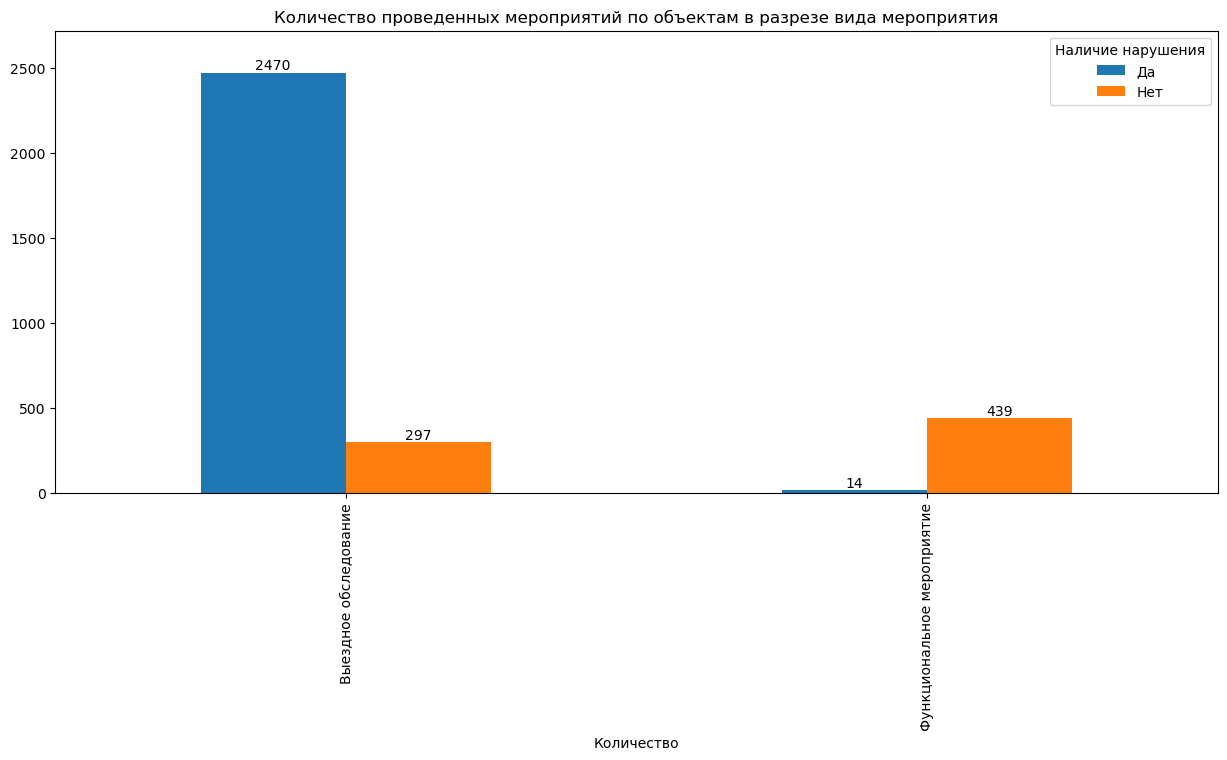

In [36]:
ax = df.groupby(['Вид мероприятия', 'Наличие нарушения'])['№ п/п'].count().unstack().plot.bar()
for i in range(2):
    ax.bar_label(ax.containers[i], label_type='edge')
    ax.margins(y=0.1)
    ax.set(ylabel=None, xlabel='Количество',title='Количество проведенных мероприятий по объектам в разрезе вида мероприятия');

Как и предпологалось, большая часть нарушений появляется при выздных проверках.

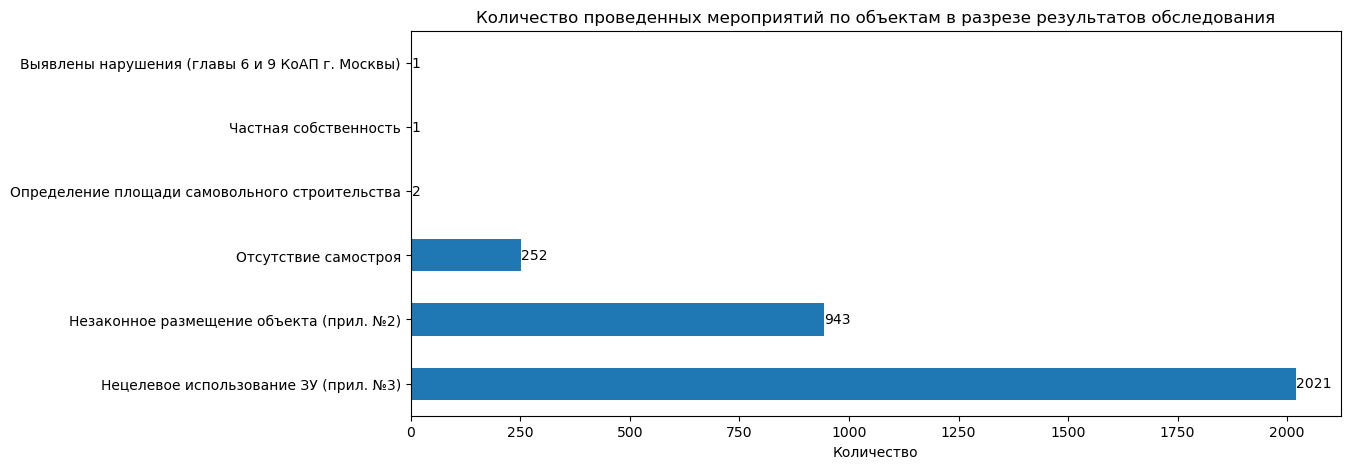

In [38]:
fig, ax = plt.subplots(figsize = (12, 5))
ax = df['Результат'].value_counts().sort_values(ascending=False).plot.barh() 

ax.bar_label(ax.containers[0], label_type='edge')
ax.margins(y=0.1)
ax.set(ylabel=None, xlabel='Количество',title='Количество проведенных мероприятий по объектам в разрезе результатов обследования');

Больне всего нарушений - это нецелевое использование ЗУ

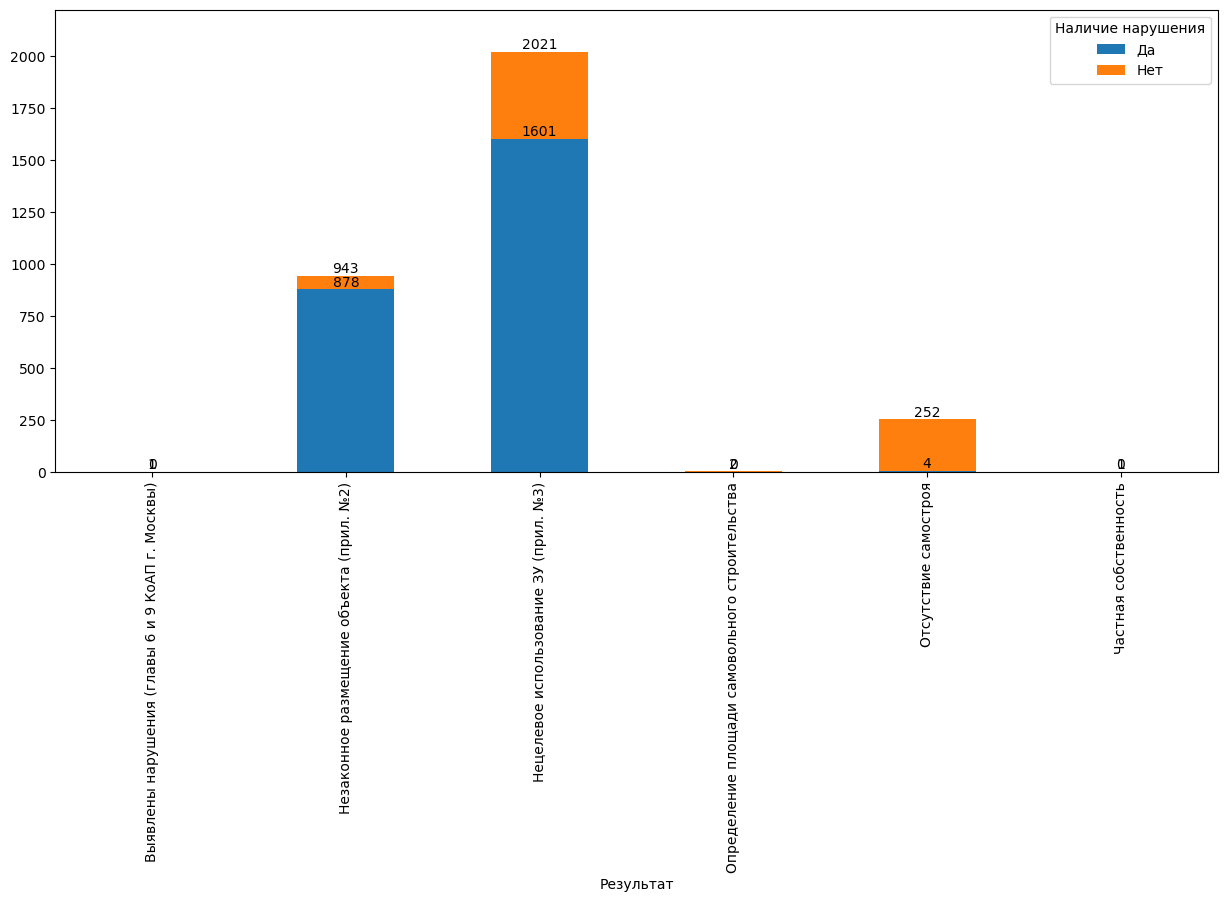

In [40]:
ax = df.groupby(['Результат', 'Наличие нарушения'])['№ п/п'].count().unstack().plot.bar(stacked=True)
for i in range(2):
    ax.bar_label(ax.containers[i], label_type='edge')
    ax.margins(y=0.1)

In [41]:
(df.groupby(['Результат', 'Наличие нарушения'])['№ п/п'].count()).reset_index().pivot(index='Результат', columns='Наличие нарушения', values = '№ п/п').sort_values(by='Да', ascending=False)

Наличие нарушения,Да,Нет
Результат,,
Нецелевое использование ЗУ (прил. №3),"1,601.00",420.00
Незаконное размещение объекта (прил. №2),878.00,65.00
Отсутствие самостроя,4.00,248.00
Выявлены нарушения (главы 6 и 9 КоАП г. Москвы),1.00,NaN
Определение площади самовольного строительства,NaN,2.00
Частная собственность,NaN,1.00


Больше всего подтвержденных нарушений - это нецелевое использование ЗУ 1601(всго мероприяйтий 2021)

## Объекты по числу мероптриятий

In [42]:
#определим объекты, которые лидируют по числу мероприятий
df.groupby(['ID объекта самостроя','Округ'])['№ п/п'].count().nlargest(10)

ID объекта самостроя  Округ
57532                 ЦАО      41
28429                 ЮЗАО      9
56280                 ЦАО       7
56554                 ЮВАО      7
12741                 СЗАО      6
52306                 ЗЕЛАО     6
52804                 ЗЕЛАО     6
56869                 ЮВАО      6
57500                 ЮВАО      6
53338                 САО       5
Name: № п/п, dtype: int64

In [43]:
df[df['ID объекта самостроя']== 57532].sort_values('№ п/п', ascending= False)

,№ п/п,Идентификатор мероприятия,№ проверки,Дата создания карточки,Вид мероприятия,Дата обновления карточки,Дата проверки/обсл,Дата акта,Продолжительность (час),Время начала осмотра,...,"Площадь факт. исп., кв.м.",Округ,Район,Площадь объекта,Право пользования,ID объекта самостроя,№ проверки без/,День недели проверки,Источник задачи,№ распоряжения/поручения
397,533,1142362,9010223,2024-01-26 16:40:15,Выездное обследование,2024-01-26 21:14:02,2024-01-25,2024-01-25,0.15,21:03,...,NaN,ЦАО,Басманный,"7,430.00",NaN,57532,9010223,4,Поручение,9010223
396,528,1142415,9010223/1,2024-01-26 19:52:23,Выездное обследование,2024-02-25 18:02:34,2024-01-25,2024-01-25,0.15,21:03,...,NaN,ЦАО,Басманный,"2,515.30",NaN,57532,9010223,4,Поручение,9010223
395,527,1142416,9010223/2,2024-01-26 19:52:48,Выездное обследование,2024-02-25 18:07:19,2024-01-25,2024-01-25,0.15,21:03,...,NaN,ЦАО,Басманный,"2,515.30",NaN,57532,9010223,4,Поручение,9010223
394,526,1142421,9010223/4,2024-01-26 20:13:02,Выездное обследование,2024-02-25 20:07:19,2024-01-25,2024-01-25,0.15,21:03,...,NaN,ЦАО,Басманный,"2,515.30",NaN,57532,9010223,4,Поручение,9010223
393,525,1142426,9010223/5,2024-01-26 20:17:41,Выездное обследование,2024-02-25 20:11:08,2024-01-25,2024-01-25,0.15,21:03,...,NaN,ЦАО,Басманный,"2,515.30",NaN,57532,9010223,4,Поручение,9010223
392,524,1142427,9010223/6,2024-01-26 20:19:06,Выездное обследование,2024-02-25 20:14:41,2024-01-25,2024-01-25,0.15,21:03,...,NaN,ЦАО,Басманный,"2,515.30",NaN,57532,9010223,4,Поручение,9010223
391,523,1142428,9010223/7,2024-01-26 20:21:11,Выездное обследование,2024-02-25 20:21:20,2024-01-25,2024-01-25,0.15,21:03,...,NaN,ЦАО,Басманный,"2,515.30",NaN,57532,9010223,4,Поручение,9010223
390,521,1142430,9010223/8,2024-01-26 20:21:57,Выездное обследование,2024-02-25 20:24:41,2024-01-25,2024-01-25,0.15,21:03,...,NaN,ЦАО,Басманный,"2,515.30",NaN,57532,9010223,4,Поручение,9010223
389,520,1142431,9010223/9,2024-01-26 20:22:37,Выездное обследование,2024-02-25 20:26:57,2024-01-25,2024-01-25,0.15,21:03,...,NaN,ЦАО,Басманный,"2,515.30",NaN,57532,9010223,4,Поручение,9010223
388,519,1142432,9010223/10,2024-01-26 20:23:46,Выездное обследование,2024-02-25 20:30:13,2024-01-25,2024-01-25,0.15,21:03,...,NaN,ЦАО,Басманный,"2,515.30",NaN,57532,9010223,4,Поручение,9010223


In [44]:
df[df['ID объекта самостроя']== 57532]['Продолжительность (час)'].sum()

6.15

Лидирует ообъкт под номром 57532. На ненго пришлось 41 мероприятие.
Сложный объект с незаконным размещеним, на который было потрачено 6 часов

In [45]:
#Посмотрим объкты с максимальным затраченным временем на них
df.groupby(['ID объекта самостроя'])['Продолжительность (час)'].sum().nlargest(10)

ID объекта самостроя
57532   6.15
58150   5.20
56280   4.69
51120   4.00
54461   3.00
51511   2.76
58293   2.72
52306   2.58
53338   2.50
57619   2.01
Name: Продолжительность (час), dtype: float64

Лидирут наш объект под номером 57532.  
Он находится в ЦАО, Басманный

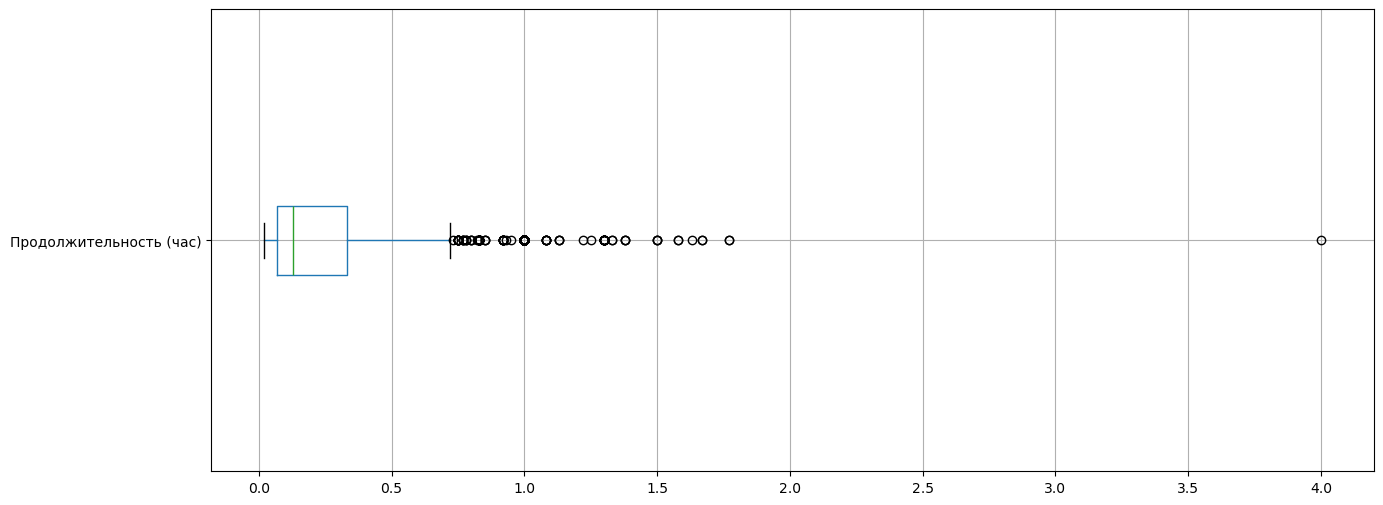

In [47]:
#определим среднее время мроприятий
df.boxplot(column='Продолжительность (час)', vert=False);

В среднем одно мероприятие занимает 8 минут. Достаточно быстро. 
Но в данных есть и сложное мероприятие, которое проходило 4 часа. 
Но наш объект с 6 часами конечно лидер!

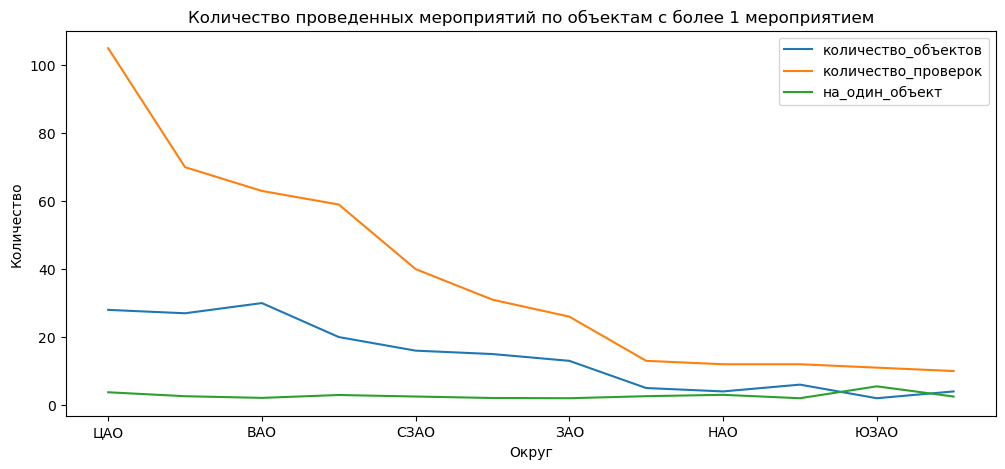

In [49]:
#отберем объекты на которых проходили мроприятия более 1
objcts = (df.groupby(['ID объекта самостроя','Округ'])['№ п/п'].count()).reset_index().rename(columns={'№ п/п':'counts'}).query('counts>1')
d = objcts.groupby('Округ').agg(количество_объектов=('ID объекта самостроя', 'count'), количество_проверок=('counts', 'sum'))
d['на_один_объект'] = d['количество_проверок']/d['количество_объектов']


fig, ax = plt.subplots(figsize = (12, 5))
d.sort_values('количество_проверок', ascending= False).plot(ax=ax)
ax.set(ylabel='Количество', xlabel='Округ',title='Количество проведенных мероприятий по объектам с более 1 мероприятием');

In [50]:
# Объекты, на которых проходили больше 1 проврки
d.sort_values('на_один_объект', ascending= False)

,количество_объектов,количество_проверок,на_один_объект
Округ,,,
ЮЗАО,2,11,5.50
ЦАО,28,105,3.75
НАО,4,12,3.00
ЗЕЛАО,20,59,2.95
САО,5,13,2.60
ЮВАО,27,70,2.59
СЗАО,16,40,2.50
ТАО,4,10,2.50
ВАО,30,63,2.10


Округ, который лидирует по числу проверок на 1 объект - это ЮЗАО, 5 проверок.

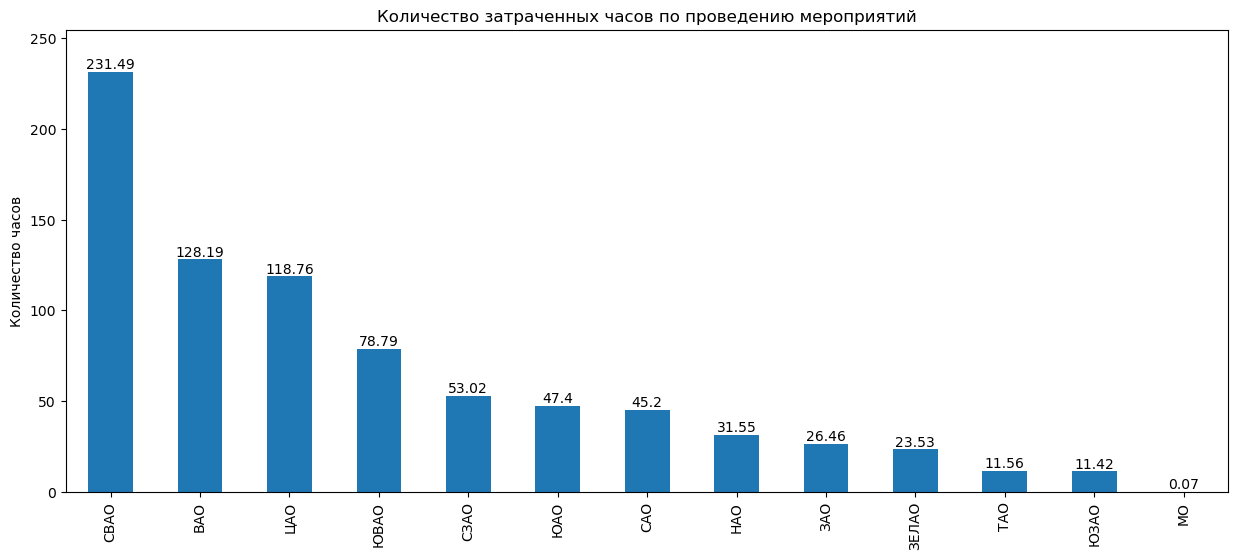

In [51]:
ax = df.groupby(['Округ'])['Продолжительность (час)'].sum().sort_values(ascending=False).plot.bar()
ax.bar_label(ax.containers[0], label_type='edge')
ax.margins(y=0.1)
ax.set(xlabel=None, ylabel='Количество часов',title='Количество затраченных часов по проведению мероприятий');

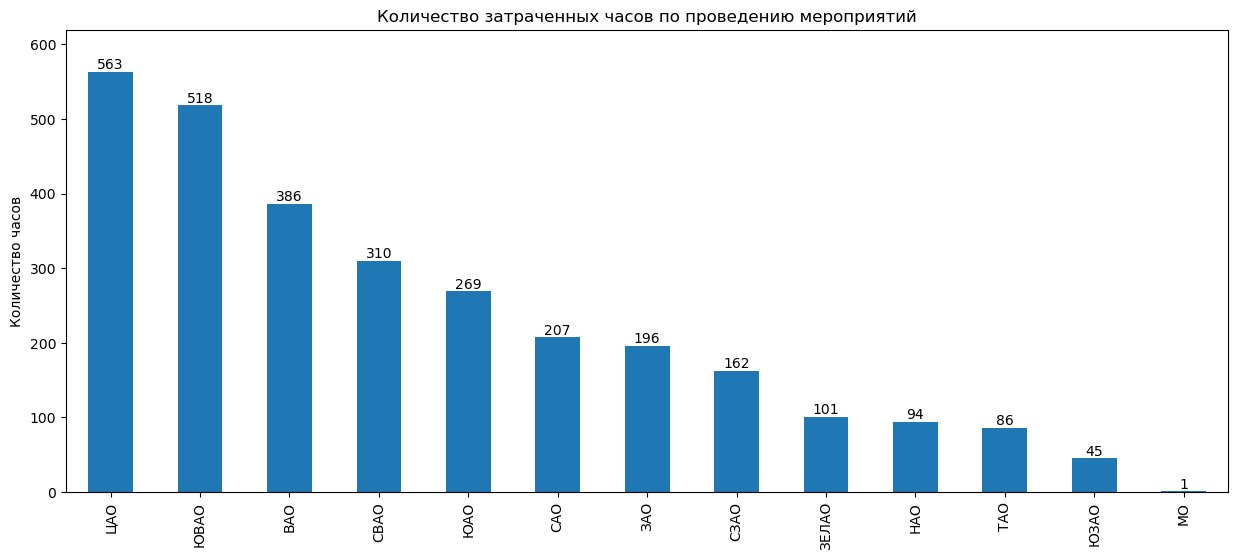

In [52]:
ax = df.groupby(['Округ'])['ID объекта самостроя'].nunique().sort_values(ascending=False).plot.bar()
ax.bar_label(ax.containers[0], label_type='edge')
ax.margins(y=0.1)
ax.set(xlabel=None, ylabel='Количество часов',title='Количество затраченных часов по проведению мероприятий');

Больше всего часов было затрачено на СВАО. Что потенциально может свидетльствовать о большом числе сложых объектов

In [54]:
#определим сколько данные совпадают в файлах с объектами
estate_c = estate_coor[['Учётный номер объекта адресации в БД БТИ (кроме помещения и комнаты)', 'Административный округ','geoData', 'geodata_center']].copy()
estate_id = estate['Идентификатор объекта'].to_list()
estate_c=estate_coor[estate_coor['Учётный номер объекта адресации в БД БТИ (кроме помещения и комнаты)'].isin(estate_id)]
estate_c.head()

,global_id,Тип объекта адресации,На территории Москвы,Полное юридическое написание адреса или описание местоположения,Учётный номер объекта адресации в БД БТИ (кроме помещения и комнаты),Субъект РФ,Поселение,Город,Муниципальный округ,Населённый пункт,...,Документ-основание регистрационных действий,Номер документа о регистрации адреса,Дата документа о регистрации адреса,Тип адреса,Вид адреса,Состояние адреса,Статус адреса,geoData,geodata_center,Unnamed: 44
27,645622703,Здание,да,"Российская Федерация, город Москва, внутригоро...",50497,город Москва,NaN,NaN,муниципальный округ Внуково,NaN,...,Распоряжение префектуры АО города Москвы,906-РП,12.07.2005,Официальный,Адрес,Зарегистрирован в АР,Внесён в ГКН,"{coordinates=[[[37.309516262, 55.609872214], [...","{coordinates=[37.309647744, 55.609750656], typ...",NaN
840,645637819,Здание,да,"Российская Федерация, город Москва, внутригоро...",50425,город Москва,NaN,NaN,муниципальный округ Косино-Ухтомский,NaN,...,Распоряжение префектуры АО города Москвы,2259-В-РП,01.11.2005,Официальный,Адрес,Зарегистрирован в АР,Внесён в ГКН,"{coordinates=[[[37.849109084, 55.714805981], [...","{coordinates=[37.849111846, 55.714719603], typ...",NaN
1171,645643932,Здание,да,"Российская Федерация, город Москва, внутригоро...",51791,город Москва,NaN,NaN,муниципальный округ Выхино-Жулебино,NaN,...,Распоряжение префектуры АО города Москвы,2260,26.10.2005,Официальный,Адрес,Зарегистрирован в АР,Внесён в ГКН,"{coordinates=[[[37.845109248, 55.695619658], [...","{coordinates=[37.845139175, 55.695704983], typ...",NaN
1336,645647063,Здание,да,"Российская Федерация, город Москва, внутригоро...",51342,город Москва,NaN,NaN,муниципальный округ Внуково,NaN,...,Распоряжение префектуры АО города Москвы,906-РП,12.07.2005,Официальный,Адрес,Зарегистрирован в АР,Внесён в ГКН,"{coordinates=[[[37.259705827, 55.613047412], [...","{coordinates=[37.259705184, 55.612988949], typ...",NaN
2039,645660369,Здание,да,"Российская Федерация, город Москва, внутригоро...",25927,город Москва,NaN,NaN,муниципальный округ Кунцево,NaN,...,Распоряжение префектуры АО города Москвы,2120-РП,22.10.2004,Официальный,Адрес,Зарегистрирован в АР,Внесён в ГКН,"{coordinates=[[[37.395574252, 55.743580621], [...","{coordinates=[37.395821382, 55.743388449], typ...",NaN


In [55]:
estate_coor.groupby('Административный округ').global_id.count()

Административный округ
Восточный административный округ            20982
Западный административный округ             22669
Зеленоградский административный округ        4572
Новомосковский административный округ      130902
Северный административный округ             19807
Северо-Восточный административный округ     17770
Северо-Западный административный округ      13447
Троицкий административный округ            183637
Центральный административный округ          26291
Юго-Восточный административный округ        18300
Юго-Западный административный округ         14345
Южный административный округ                18573
Name: global_id, dtype: int64

In [56]:
estate_c.groupby('Административный округ').global_id.count()

Административный округ
Восточный административный округ            40
Западный административный округ            168
Зеленоградский административный округ       11
Новомосковский административный округ        2
Северный административный округ             11
Северо-Восточный административный округ     12
Северо-Западный административный округ      21
Центральный административный округ          17
Юго-Восточный административный округ         8
Юго-Западный административный округ         47
Южный административный округ                 2
Name: global_id, dtype: int64

In [57]:
#количество объектов, по которым рошли проверки и которые зарегестрированы
estate_c.groupby('Административный округ').global_id.count().sum()

339

In [58]:
#Всего объектов по котороым прошли проверки
estate['Идентификатор объекта'].nunique()

2937

Их всех объектов, которые зарегестрированы в реестре и покоторым прошли проверки 339.
Это 10% от всего количества объектов. 90% объектов имеют нарушения

**Вывод:**
    
в данных представлен 2937 бъект

Обекты были классифицированы по расположению в АО
*Округ*
- ЦАО      563
- ЮВАО     518
- ВАО      386
- СВАО     310
- ЮАО      269
- САО      207
- ЗАО      196
- СЗАО     162
- ЗЕЛАО    101
- НАО       94
- ТАО       86
- ЮЗАО      45
- МО         1

*По количеству мероприятий*
ID объекта самостроя  Округ
- 57532                 ЦАО      41
- 28429                 ЮЗАО      9
- 56280                 ЦАО       7
- 56554                 ЮВАО      7
- 12741                 СЗАО      6
- 52306                 ЗЕЛАО     6
- 52804                 ЗЕЛАО     6
- 56869                 ЮВАО      6
- 57500                 ЮВАО      6
- 53338                 САО       5

Выявлены лидеры по количеству потрачного врмни на проверку
ID объекта самостроя Продолжительность (час)
- 57532   6.15
- 58150   5.20
- 56280   4.69
- 51120   4.00
- 54461   3.00
- 51511   2.76
- 58293   2.72
- 52306   2.58
- 53338   2.50
- 57619   2.01

**Источник задачи**
Больше всего представлены оручения руководителя
- Поручение                          2215
- ЭДО обращение ОИВ                   583
- Камеральная проверка                142
- Мониторинг ОИВ                      110

Их всех объектов, которые зарегестрированы в реестре и покоторым прошли проверки 339.  
Это 10% от всего количества объектов. 90% объектов имеют нарушения


Далее визуализируем полученные данны на дашборде.

In [60]:
#выгрузка данных для визуализации
#задачи и мероприятия
df.to_csv('df.csv')

In [61]:
#объекты
estate.to_csv('estate')

In [62]:
#данные по зарегестрированным объктам
estate_coor.to_csv('estate_coor')